In [2]:
import os
import pandas as pd
import numpy as np
import glob

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_formatrmat = 'retina'

In [3]:
from stesml.data_tools import get_train_and_test_index
from stesml.data_tools import load_data
from stesml.data_tools import series_to_supervised
from stesml.data_tools import get_train_data
from stesml.data_tools import get_test_data

from stesml.model_tools import get_model
from stesml.model_tools import walk_forward_validation
from stesml.model_tools import get_predictions
from stesml.model_tools import get_progress

from stesml.postprocessing_tools import get_h

from stesml.plot_tools import get_plot_data
from stesml.plot_tools import plot_test_results
from stesml.plot_tools import plot_average_error
from stesml.plot_tools import plot_error_vs_T
from stesml.plot_tools import plot_progress_results

/Users/kmenear/Projects/sulfurTES/sulfurTESenv/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
data_dir = "../data/Air_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "IG_*_*.csv"))})

In [293]:
model_type = "XGBoost"
is_recurrent = False
n_estimators = 100

In [316]:
from typing import Tuple

def relu(x):
    return max(x,0)

def focal_obj(X_train):
    def custom_obj(y: np.ndarray, y_hat: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        rows = y.shape[0]
        zeros = np.zeros((rows), dtype=float)
        ones = np.ones((rows), dtype=float)
        grad = np.zeros((rows), dtype=float)
        hess = np.zeros((rows), dtype=float)
        Tw = X_train[:,1]
        Ti = X_train[:,2]
        # (y_hat - y)^2 + relu(Ti-y_hat) + relu(y_hat - Tw)
        grad = 4*(y_hat - y) - 0*np.maximum((Ti - y_hat),zeros) + 0*np.maximum((y_hat - Tw),zeros)
        hess = 4*ones + 0*np.maximum(np.sign(Ti - y_hat),zeros) + 0*np.maximum(np.sign(y_hat - Tw),zeros)
        grad = grad.reshape((rows, 1))
        hess = hess.reshape((rows, 1))
        return grad, hess
    return custom_obj

In [7]:
train_index, test_index = get_train_and_test_index(scenario_index)

X_train, y_train = get_train_data(scenario_index, train_index, is_recurrent)
X_test, y_test = get_test_data(scenario_index, test_index, is_recurrent)

In [230]:
model = get_model(model_type, n_estimators)

In [317]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=n_estimators, colsample_bylevel=.75, objective=focal_obj(X_train))

In [312]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1,
             objective=<function focal_obj.<locals>.custom_obj at 0x7fda28fb91b0>,
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [313]:
y_hat = get_predictions(model, X_test, is_recurrent)

In [314]:
print(r2_score(y_test, y_hat))

0.9975036385915701


In [315]:
print(mean_squared_error(y_test, y_hat, squared=False))

3.6331550908234287


In [12]:
test_df = load_data(scenario_index, test_index, is_recurrent_test_data=True)
h = get_h(test_df[5])

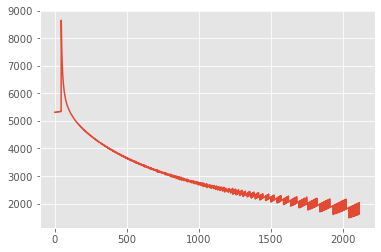

In [13]:
import matplotlib.pyplot as plt
window = 25
average_h = []
for ind in range(len(h) - window + 1):
    average_h.append(np.mean(h[ind:ind+window]))
    
plt.plot(h)

In [289]:
test_df = load_data(scenario_index, test_index)
test_df_plot = get_plot_data(y_hat, test_df, test_index, is_recurrent)

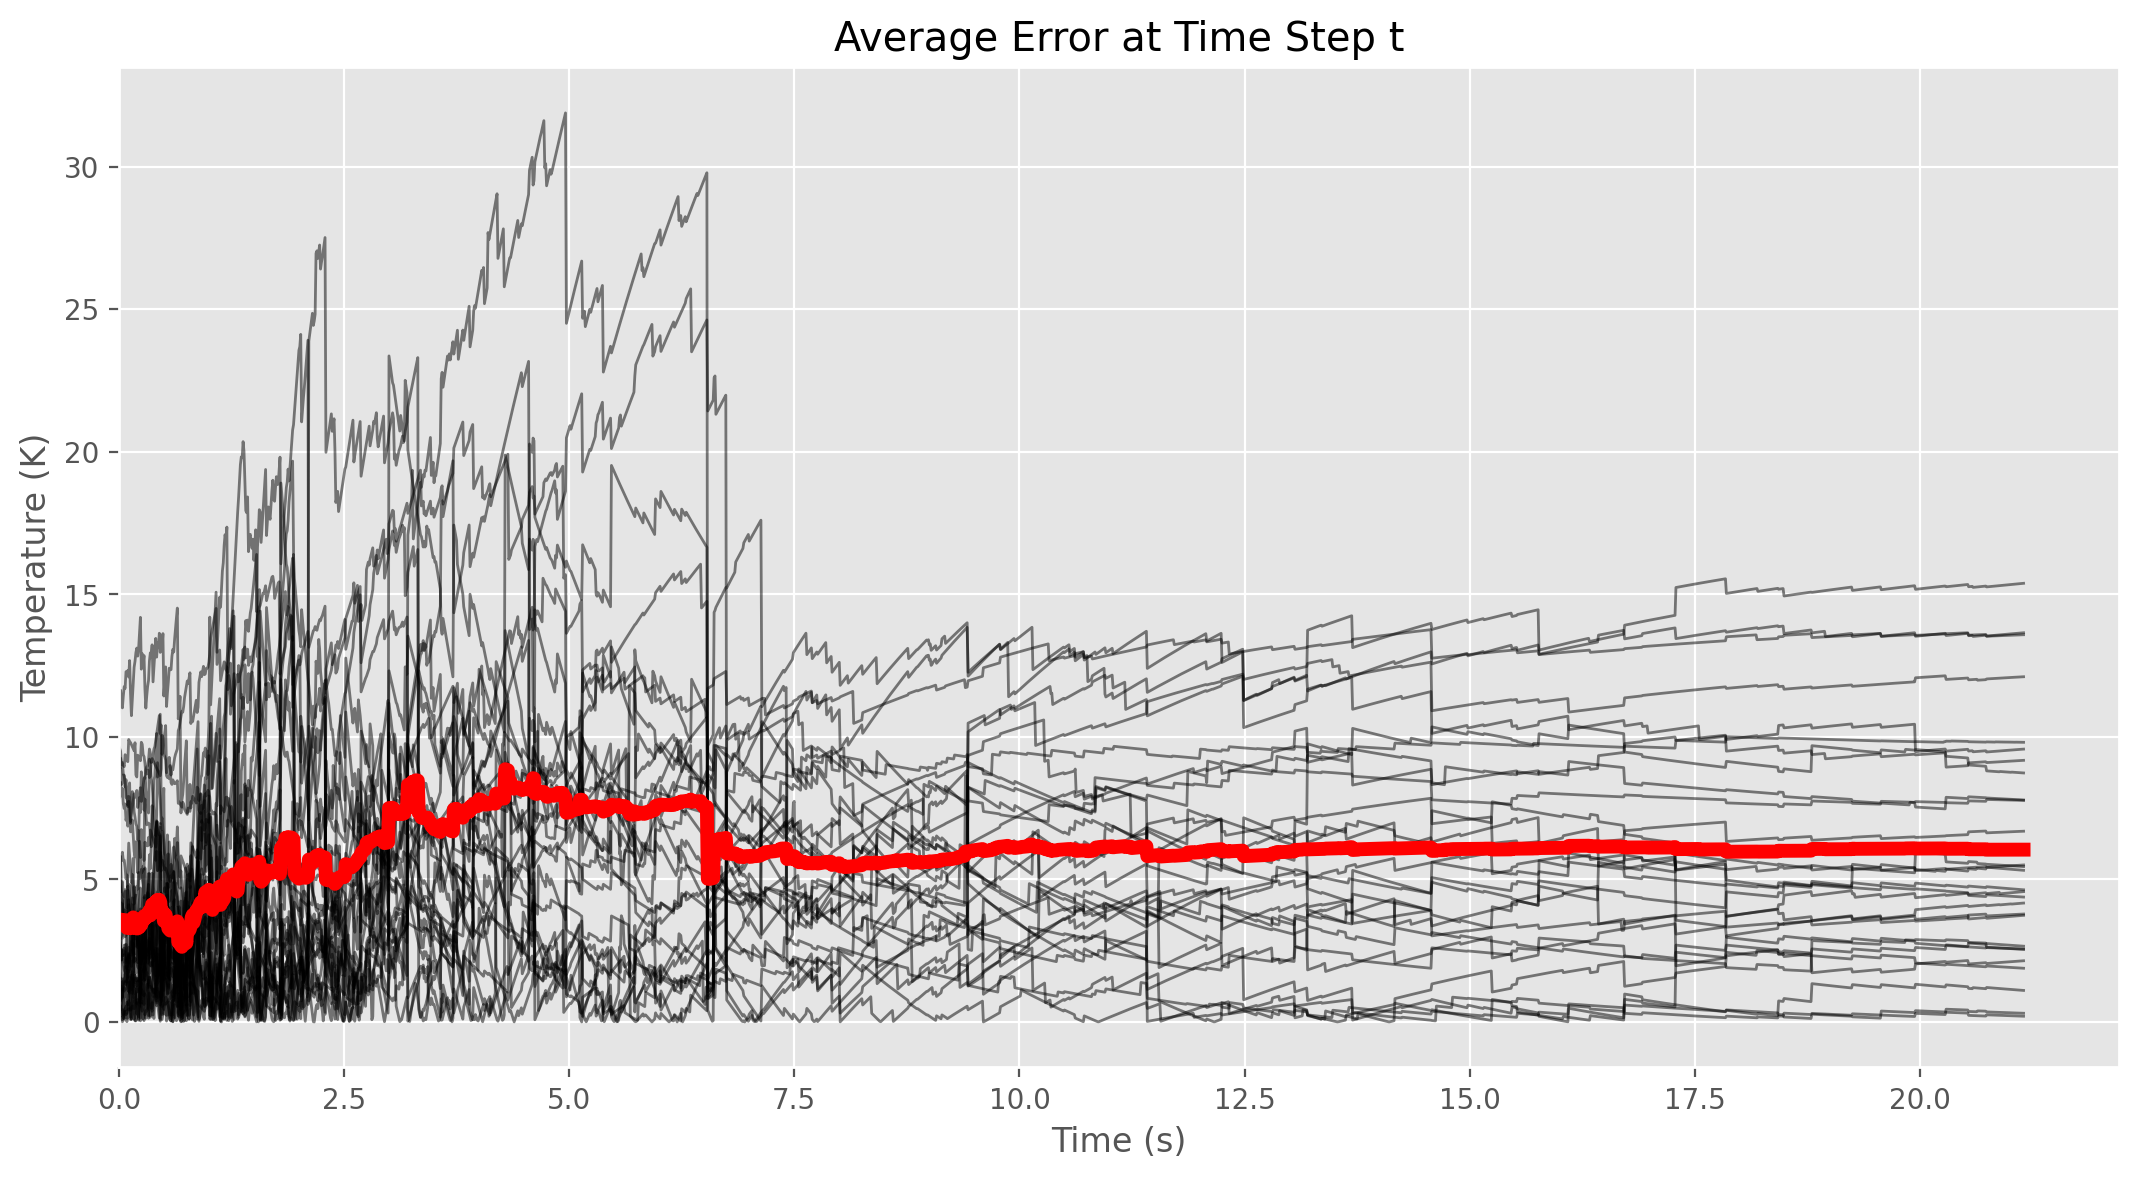

In [211]:
plot_average_error(test_df_plot)

<AxesSubplot:>

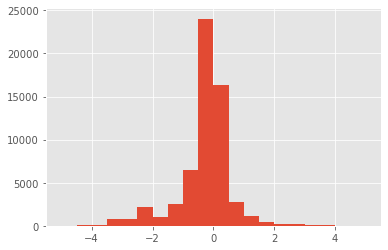

In [138]:
(100*(test_df_plot["Tc"] - test_df_plot["Tc_hat"])/test_df_plot["Tc"]).hist(bins=20, range=(-5, 5))

<AxesSubplot:>

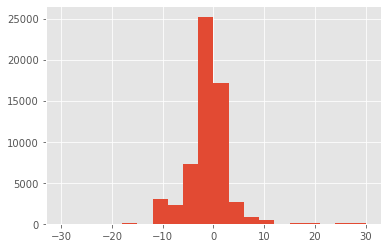

In [139]:
(test_df_plot["Tc"] - test_df_plot["Tc_hat"]).hist(bins=20, range=(-30, 30))

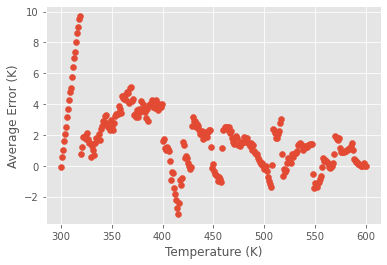

In [140]:
plot_error_vs_T(test_df_plot)

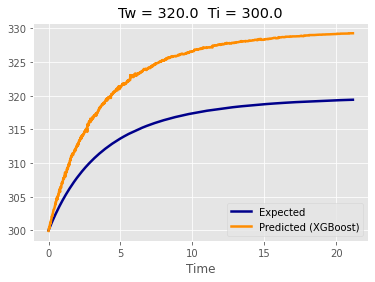

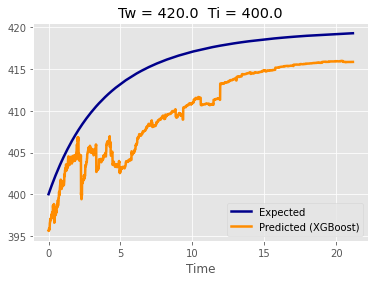

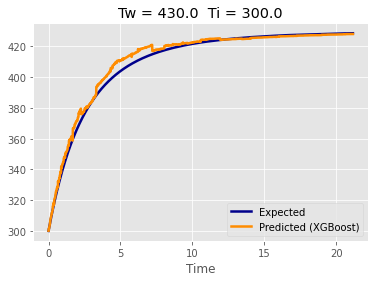

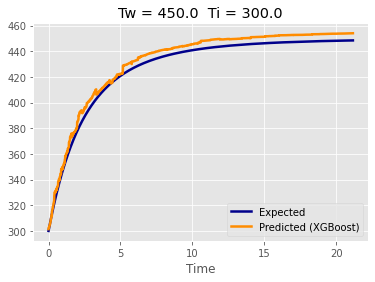

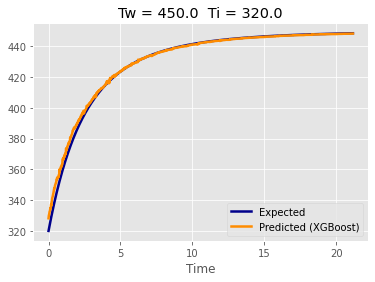

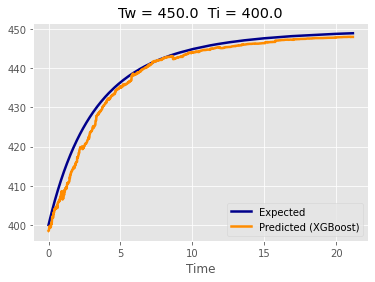

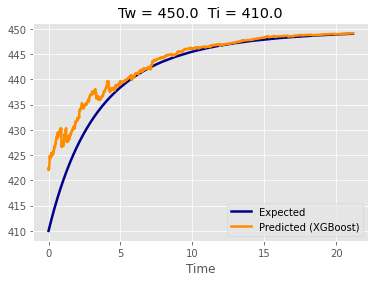

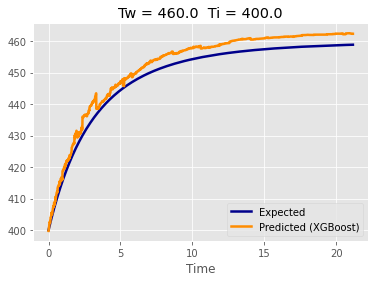

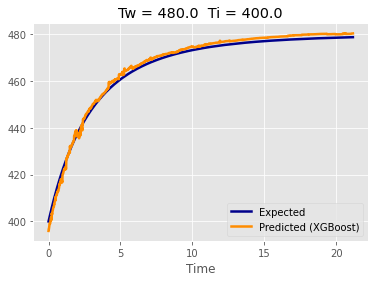

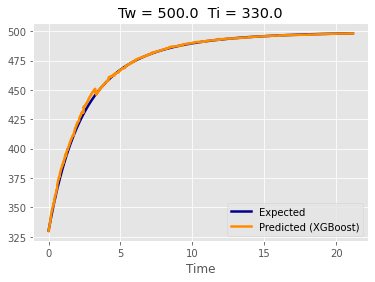

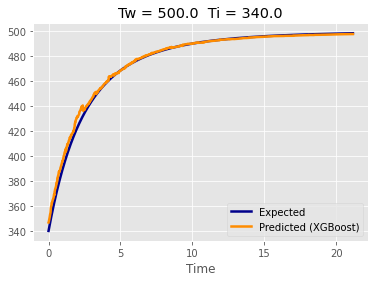

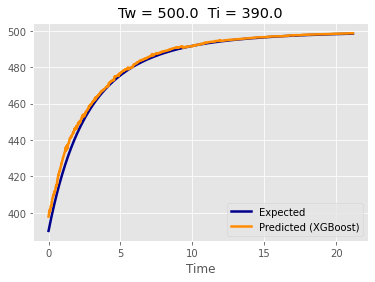

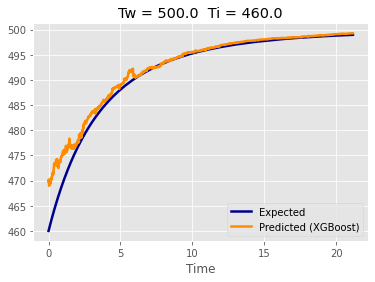

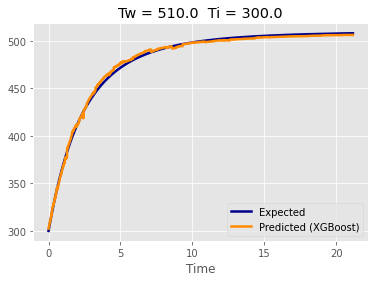

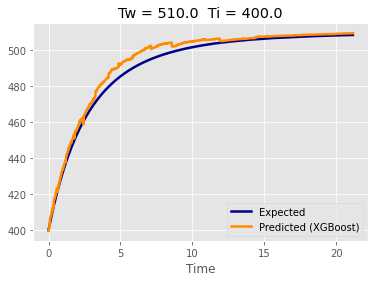

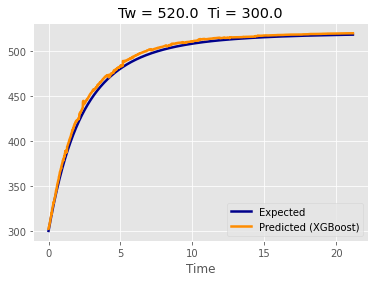

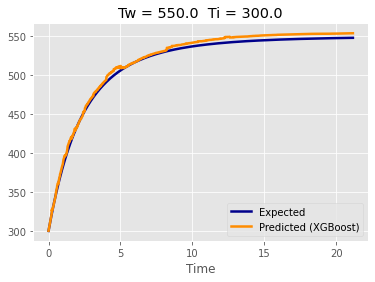

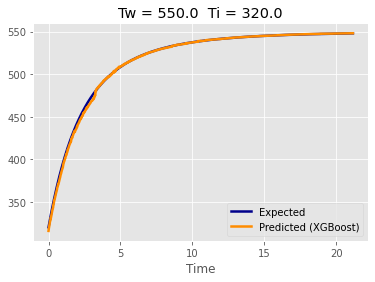

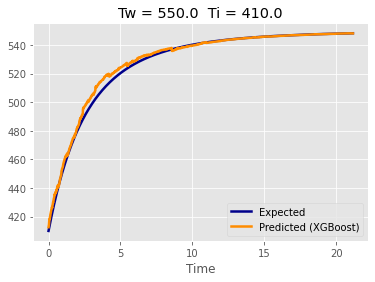

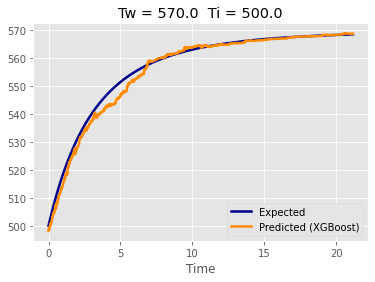

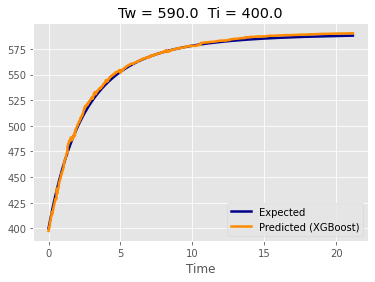

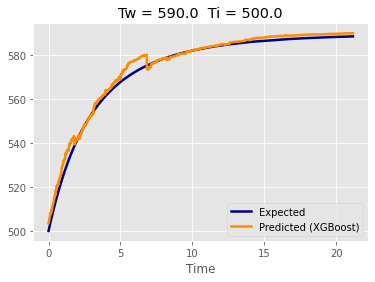

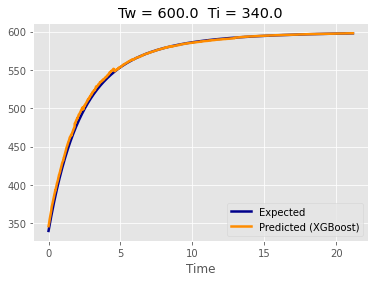

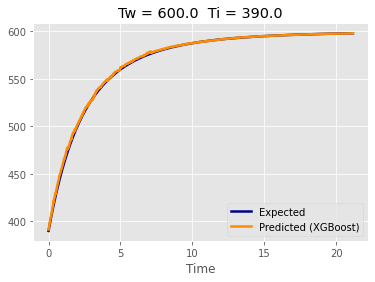

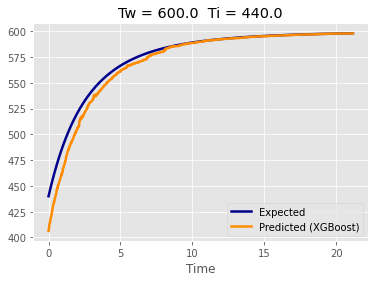

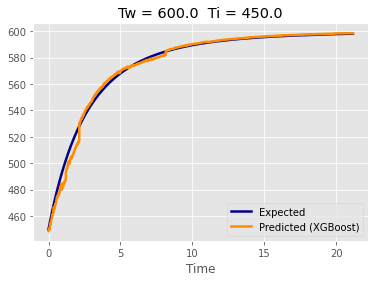

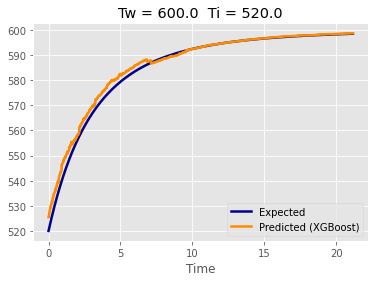

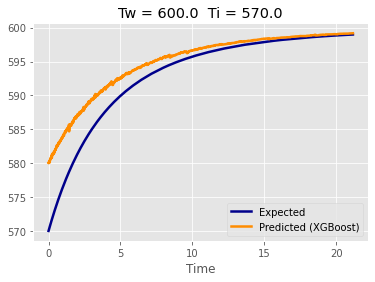

In [290]:
plot_test_results(test_df_plot, model_type)

In [29]:
min_estimators = 8
max_estimators = 10
step_size = 1
num_shuffle_iterations = 2

rmse_history, r2_history = get_progress(model_type, scenario_index, min_estimators, max_estimators, step_size, num_shuffle_iterations, is_recurrent)

# of Estimators: 8, RMSE = 195.74738, r2 = -7.26154
# of Estimators: 9, RMSE = 154.95436, r2 = -3.18066
# of Estimators: 10, RMSE = 152.78211, r2 = -3.51312


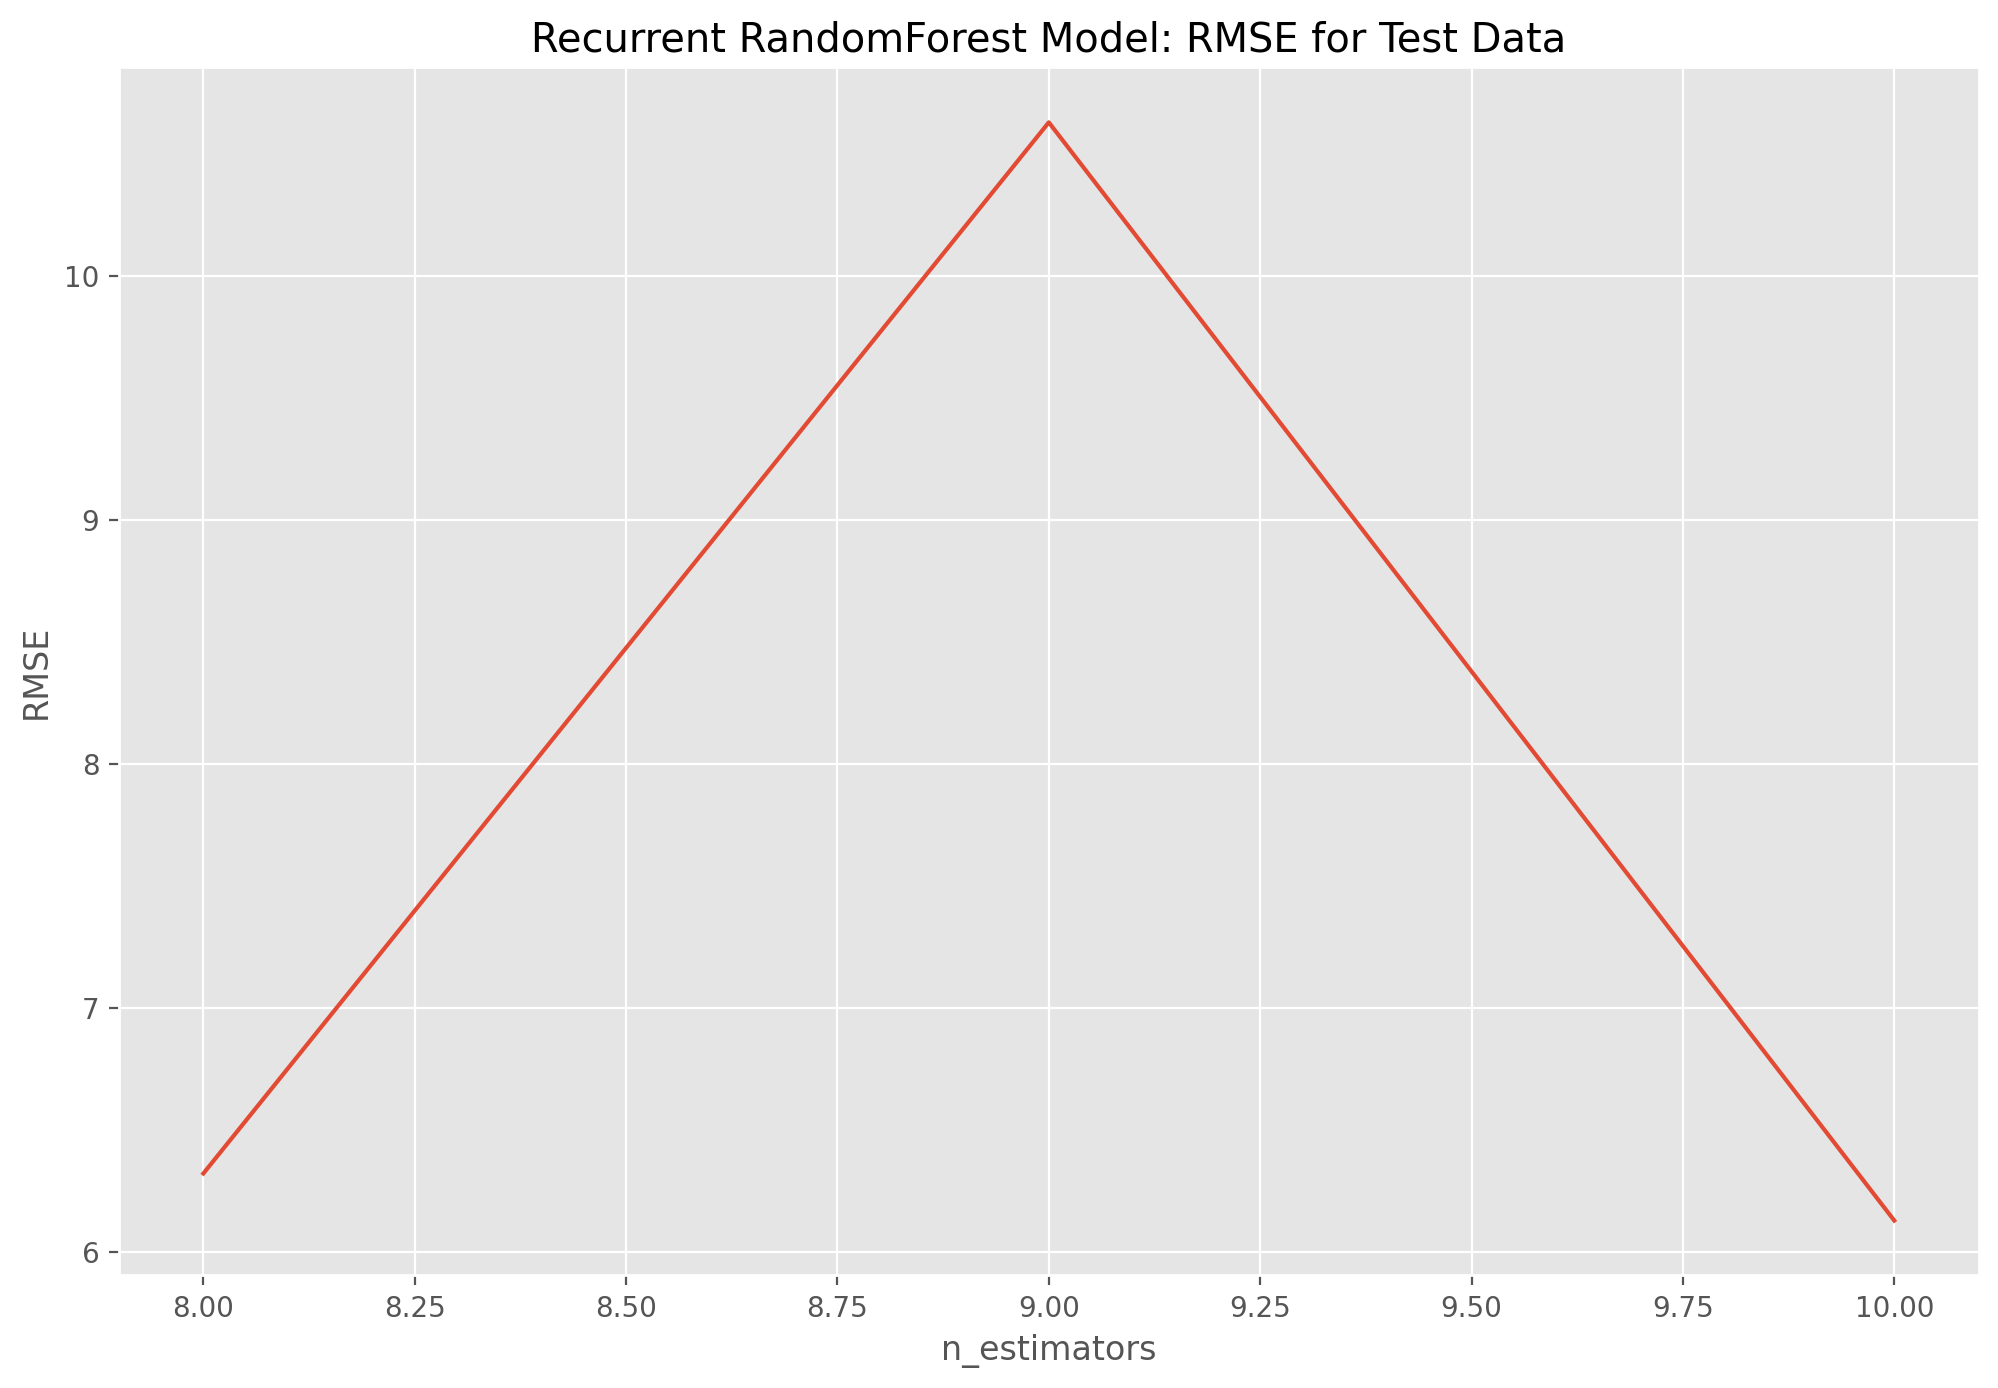

In [16]:
plot_progress_results(rmse_history, model_type, is_recurrent, metric="RMSE")

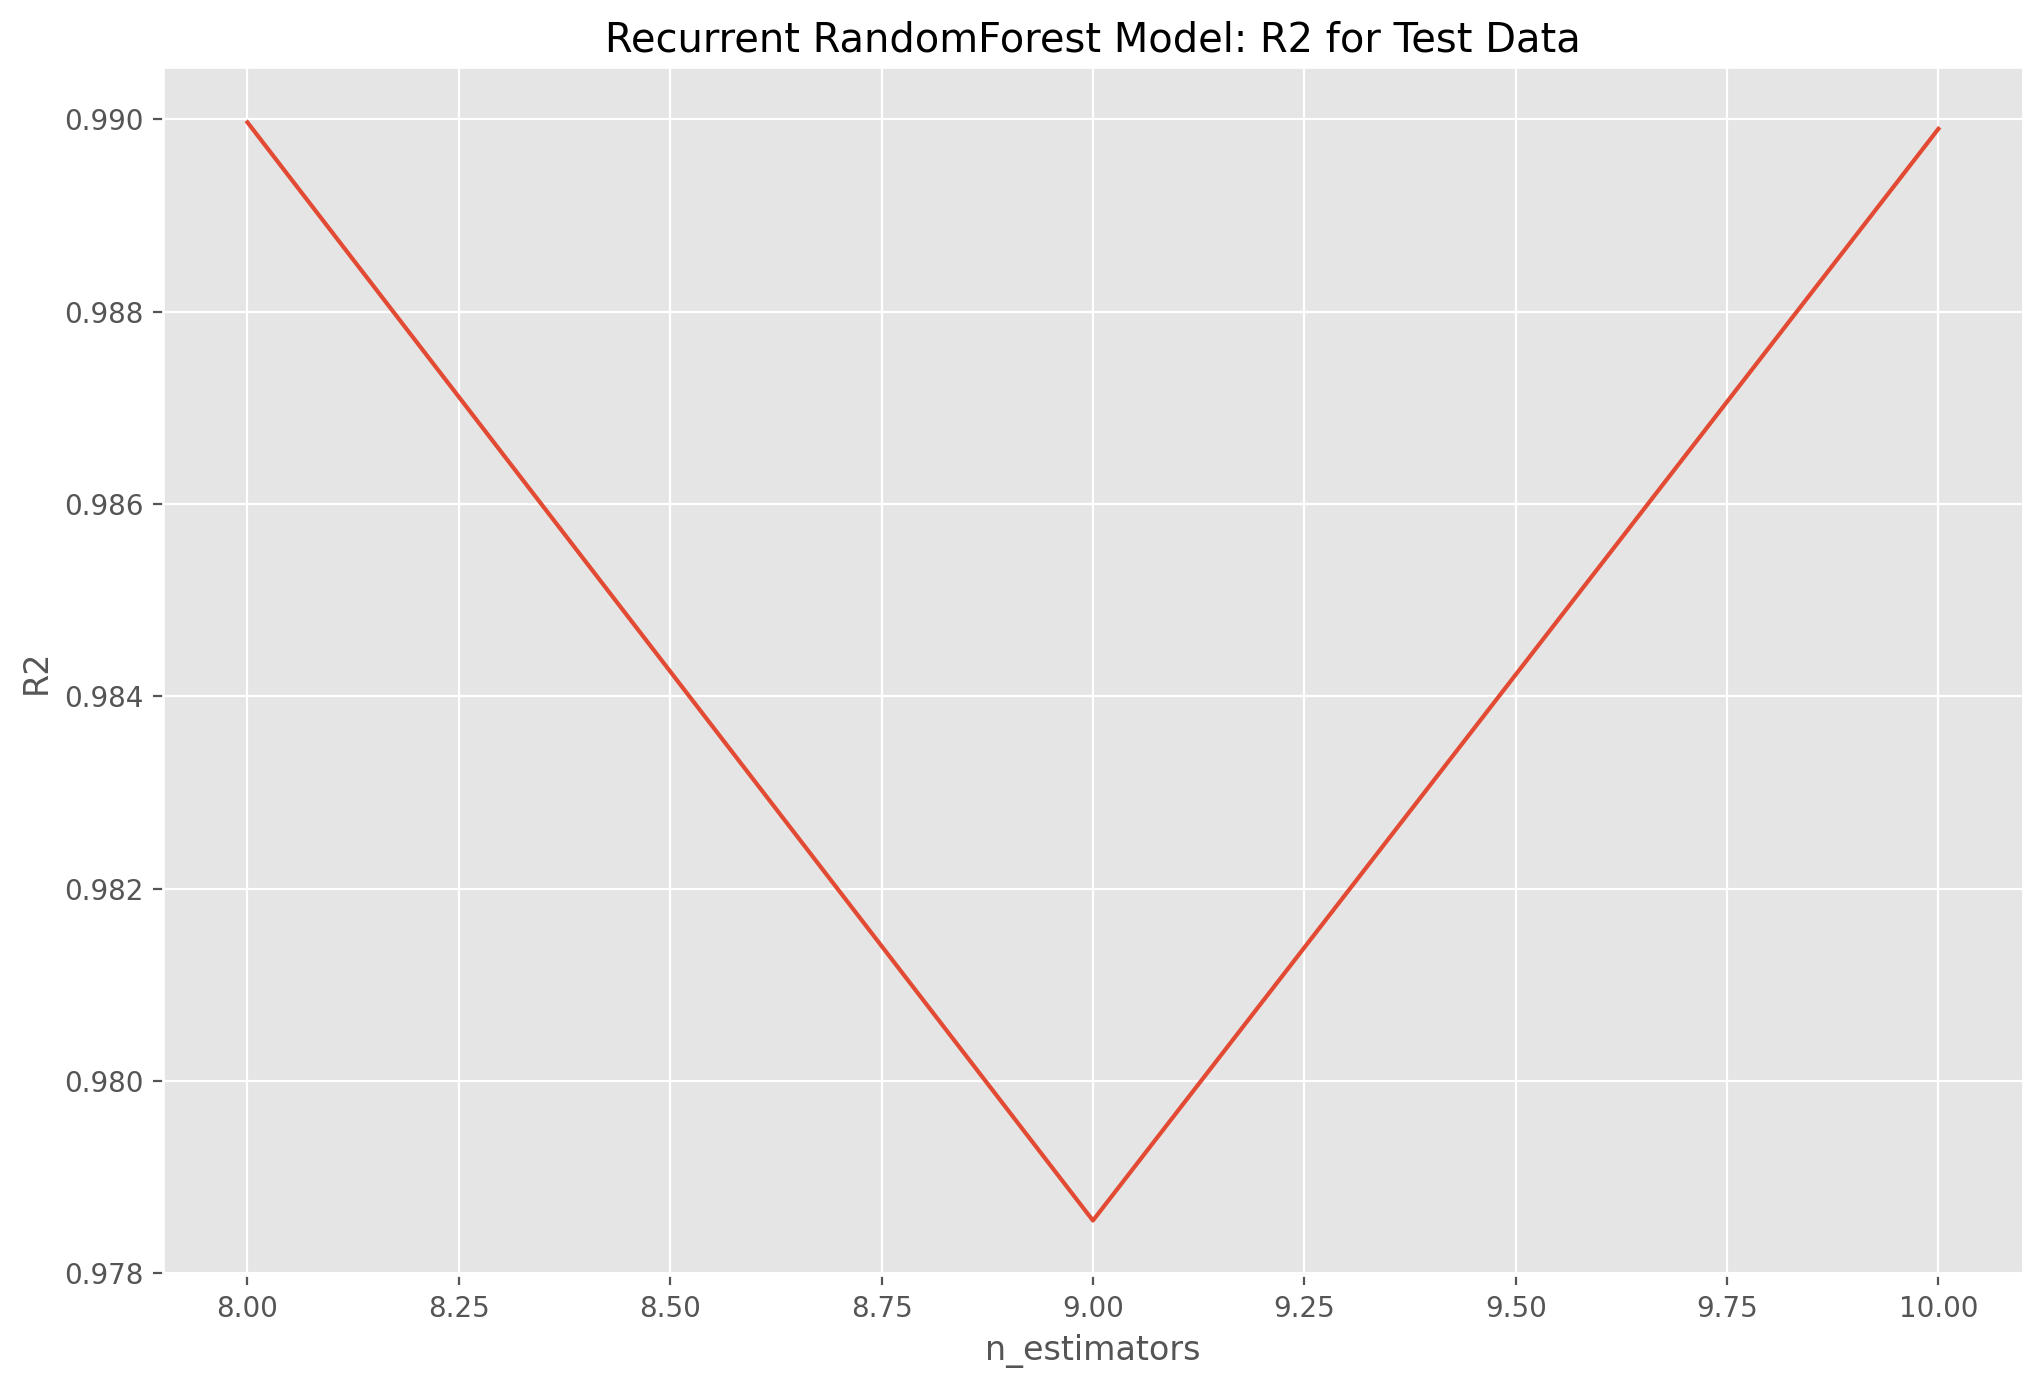

In [17]:
plot_progress_results(r2_history, model_type, is_recurrent, metric="R2")